1. [신경망] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.(14점)
(코드의 해석과 결과의 의미를 작성하세요.)

In [1]:
# torch.nn 패키지를 사용하여 신경망을 생성함.
# nn 패키지는 모델을 정의할 때, autograd를 통해 자동미분 기능을 제공함
# nn.Module은 층과 전방전파(forward propagation) (입력 -> 출력)을 쉽게 구현함
# 참고로 nn 패키지는 mini-batch만 지원함, 
# 예로 nn.Conv2d는 4차 Tensor를 받음(nSamples*nChannels*height*width)
# 아래 AlexNet(이미 수업에서 학습함.) 예시는 숫자를 분류하는 간단한 컨볼루션 신경망의 예임

![](figure/AlexNet.png)

In [2]:
# 예시는 사진 입력을 받고, 몇 개의 층에 전방 전파하면서 분류를 출력함
# 출력을 위해서 모델은 다음과 같은 학습을 수행함
# - 신경망은 학습가능한 매개변수들(가중치들)을 가짐
# - 사진 데이터를 반복적으로 입력함
# - 신경망을 통해 입력을 처리함(전방 전파)
# - 손실(오차)를 계산함(실제 출력과 예측 출력을 비교하여 학습의 올바름을 판단함)
# - 오차로부터 그레이디언트(경사, 방향)을 신경망의 각 매개변수에게 역전파함(오류 역전파)
# - 신경망의 매개변수들을 갱신함((미래)가중치 = (현재)가중치 - 학습률 * 그레이디어트)


# 위의 컨볼루션 신경망의 부분들을 torch를 통해서 손쉽게 구현할 수 있음.
# 단지 forward 함수만 정의하면, autograd를 이용해서 
# 해당 연산 그래프의 그레이디언트를 구하는 backward 자동적으로 정의됨.
# forward 함수는 Tensor를 이용할 수 있는 다양한 연산들(합, 곱 등등) 사용하여 정의 가능함.
# torch.Tensor: 자동 미분 기능을 지원하는 다차원 배열, 각 Tensor에 해당하는 그레이디언트를 가짐.
# nn.Module: 신경망 모듈이며 매개변수의 캡슐화, GPU 연산 등 작업을 쉽게 가능하게 함.
# nn.Parmeter: 모듈이 지정되면 매개변수들을 자동으로 관리하는 Tensor의 하나임. 

import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        # for parent class 
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel(filter)
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 6 input image channer, 16 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # reshape in tensorflow
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # output layer
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

# (1) 화면 출력 확인 및 의미를 서술

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


위의 출력은 Network 구성을 보여준다. 

- convolution1(1 = input depth, output depth = 6, kernel = 5 x 5, stride=1)
- convolution2(6 = input depth, output depth = 16, kernel = 5 x 5, stride=1)
- fully-connected layer(input_node = 400, output_node=120, including=bias term)
- fully-connected layer(input_node = 120, output_node=84, including=bias term)
- fully-connected layer(input_node = 84, output_node=10, including=bias term)

물론 각 layer 마다 activation function으로 ReLU(rectified Linear unit)을 사용하는
CNN의 구조를 보여준다.(마지막 output layer에서는 activation function을 사용하지 않는다.) 

In [3]:
# (2) 정의된 컨볼루션 신경망의 구조 설명 (위의 AlexNet 그림 참고)

전체적인 구조는 

- convolution1(1 = input depth, output depth = 6, kernel = 5 x 5, stride=1)
- max_pooling(convolution1) : subsampling
- convolution2(6 = input depth, output depth = 16, kernel = 5 x 5, stride=1)
- max_pooling(convolution2) : subsampling
- fully-connected layer(input_node = 400, output_node=120, including=bias term)
- fully-connected layer(input_node = 120, output_node=84, including=bias term)
- fully-connected layer(input_node = 84, output_node=10, including=bias term)

물론 각 layer 마다 activation function으로 ReLU(rectified Linear unit)을 사용하는
CNN의 구조를 보여준다.(마지막 output layer와 max pooling에서는 activation function을 사용하지 않는다.) 
위와 코드는 위와 같은 구조로 구성되어진다. 

In [4]:
# net.parameters()를 사용하여 정의된 신경망의 학습가능한 매개변수들을 확인할 수 있음
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight
# (3) 화면 출력 확인
# 위에서 설계한 convolution network의 매개변수 수와 
# first conv layer의 weight size를 출력을 하고 있다. 

10
torch.Size([6, 1, 5, 5])


In [5]:
# 다음의 임의의 32*32 입력을 가정함
# 참고로 크기가 다른 입력을 받을 때는 입력의 크기를 재조정하거나 신경망 수정함
# 입력 이미지 크기 batch, channel, height, width
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)
# (4)화면 출력 확인
# 최종 10개의 class의 분류 score를 보여주고 있다. 

tensor([[ 0.0340, -0.0876,  0.0137, -0.0112, -0.0884, -0.0848,  0.0645,  0.1451,
         -0.1455, -0.0678]], grad_fn=<ThAddmmBackward>)


In [6]:
# 오류역전파를 통해 그레이디언트를 구하기 전에 모든 가중치의 그레이디언트 버퍼들을 초기화 
net.zero_grad()
# in backward, compute gradient w.r.t torch.randn(1,10) tensor
out.backward(torch.randn(1,10))

# 손실 함수 정의 및 임의의 값들에 대해서 오차 결과 확인
# nn 패키지는 많이 사용되는 손실함수들을 제공하며, 해당 예제는 단순한 MSE를 사용
output = net(input)
target = torch.randn(10) # a dummy target, for example
print(target)
target = target.view(1, -1) # make it the same shape as output
print(target)
criterion = nn.MSELoss()


loss = criterion(output, target)
print("Checking loss value")
print(loss)
# (5) 화면 출력 확인

tensor([ 0.6554,  0.3266,  2.7215,  0.1066, -0.3627, -0.8609,  0.3992,  0.2910,
         1.5681, -0.3191])
tensor([[ 0.6554,  0.3266,  2.7215,  0.1066, -0.3627, -0.8609,  0.3992,  0.2910,
          1.5681, -0.3191]])
Checking loss value
tensor(1.1714, grad_fn=<MseLossBackward>)


In [7]:
# 앞에 코드에서 언급한 것과 같이 오류 역전파하기 전, 그레이디언트를 초기화해야 함
# backward() 수행 후 어떤 변화가 있는지 확인하고, 초기화의 필요성을 확인함
net.zero_grad() # zeroes the gradient buffers of all parameters

print("conv1.bias.grad before backward")
print(net.conv1.bias.grad)
# (6) 화면 출력 확인
# 오류 역전파하기전의 conv1.bias의 gradient를 값을 보여준다. 
# 오류 역전파하기전인 만큼 0의 값으로 초기화 되어진다.

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])


In [8]:
# loss에 기반하여 backward를 실행한다.
loss.backward()

print("conv1.bias.grad after backward")
print(net.conv1.bias.grad)
# (7) 화면 출력 확인
# 오류 역전파가 수행이 되면서 
# conv1.bias의 gradient 값을 보여준다.

conv1.bias.grad after backward
tensor([ 0.0217, -0.0128, -0.0124, -0.0127,  0.0030,  0.0105])


In [9]:
# 스토캐스틱경사하강법((미래)가중치 = (현재)가중치 - 학습률* 그레이디언트)을
# 이용하여 가중치 갱신하는 코드는 다음과 같음
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

# 하지만 위 구현 코드보다 실제, torch.optim에서 구현되는 SGD, Adam, RMSProp 등을 사용함
# 오류 역전파에서 최적화하는 방법을 보인 예제 코드
import torch.optim as optim

# create your optimizer 
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad() # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step() # Does the update

2. [분류기 학습] 다음 코드를 무엇을 의미하는지 이해하고 실행하여 결과를 확인하세요.(14점)
(코드의 해석과 결과의 의미를 작성하세요.)

In [10]:
# 1번의 기초적인 신경망을 통해서 사진 분류기를 학습함
# 데이터집합은 CIFAF-10이며, 
# 아래의 예와 같이 10가지의 3(R, G, B) 채넝릐 32*32 크기의 사진으로 구성됨

![](figure/CIFAR_10.png)

In [11]:
# CIFAR-10과 같이 많이 사용되는 데이터집합은 torchvision 패키지에서 제공함
# 분류기 학습은 다음과 같은 과정을 가짐
# 1. 정규화된 CIFAR-10 훈련집합과 테스트집합을 torchvision을 이용하여 적재함
# 2. 컨볼루션 신경망을 정의함
# 3. 손실함수 정의
# 4. 훈련집합을 이용하여 신경망을 학습시킴
# 5. 테스트집합을 이용하여 신경망 성능 확인

### 1. 정규화된 CIFAR-10 훈련집합과 데스트 집합을 torchvision을 이용하여 적재함
import torch
import torchvision
import torchvision.transforms as transforms


# transforms.Normalize function normalize a tensor image with -
# mean and standard deviation channel by channel
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# (1) 화면 출력 확인
print("trian set: {}".format(len(trainset)))
print("test set: {}".format(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
trian set: 50000
test set: 10000


In [12]:
# 훈련집합의 일부 사진들 확인
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print("The size of image tensor:", images.size())
print("The size of label tensor:", labels.size(), labels[0])
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# (2) 화면 출력 확인

The size of image tensor: torch.Size([4, 3, 32, 32])
The size of label tensor: torch.Size([4]) tensor(2)
 bird   car truck truck


In [13]:
### 2. 컨볼루션 신경망을 정의함
# 3 채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10분류를 수행
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### 3. 손실함수 정의, 교차 엔트로피와 SGD + Momentum
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print("[%d, %5d]loss: %.3f" % (epoch + 1, i +1, running_loss / 1000))
            running_loss = 0.0
            
            
print("Finished training")
# (3) 화면 출력 확인 및 학습이 되고 있는지 서술

[1,  1000]loss: 2.292
[1,  2000]loss: 2.128
[1,  3000]loss: 1.936
[1,  4000]loss: 1.807
[1,  5000]loss: 1.727
[1,  6000]loss: 1.665
[1,  7000]loss: 1.599
[1,  8000]loss: 1.564
[1,  9000]loss: 1.534
[1, 10000]loss: 1.495
[1, 11000]loss: 1.485
[1, 12000]loss: 1.449
[2,  1000]loss: 1.431
[2,  2000]loss: 1.428
[2,  3000]loss: 1.370
[2,  4000]loss: 1.376
[2,  5000]loss: 1.381
[2,  6000]loss: 1.327
[2,  7000]loss: 1.338
[2,  8000]loss: 1.318
[2,  9000]loss: 1.303
[2, 10000]loss: 1.318
[2, 11000]loss: 1.311
[2, 12000]loss: 1.292
Finished training


위의 loss 값을 확인해보면 점차 낮아지는 방향으로 학습이 진행이 되고 있다.

GroundTruth:   cat  ship  ship plane


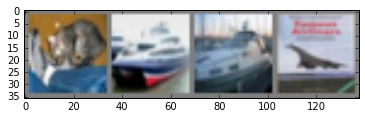

In [14]:
### 5. 테스트 집합을 이용하여 신경망 성능 확인
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("GroundTruth:", ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# (4) 화면 출력 확인

In [15]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print("Predicted:", ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
# (5) 화면 출력 확인
# 예측된 label의 type을 출력하고 있다. 
print("예측된 label의 type을 출력하고 있다. ")

Predicted:   cat  ship  ship plane
예측된 label의 type을 출력하고 있다. 


In [16]:
# Perfomance on the whole test dataset 
correct = 0 
total = 0 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct/total))
# (6) 화면 출력 확인 및 일반화 성능 서술

Accuracy of the network on the 10000 test images: 54 %


위의 결과를 보면 알 수 있듯 일반화 성능은 testset을 가지고 나타낼 수 있는데 
이것은 training을 할 때 사용하지 않은 데이터를 가지고 나의 모델이 training되지 않은 
데이터를 얼마나 잘 예측을 할 수 있는지 수치를 정확도로 판단하는데 현재 모델은 
정확도(accuracy) 54%를 보여준다. 

In [17]:
# Performance on each class 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
print("The initial class_correct:", class_correct)
print("The initial class_total:", class_total)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(output, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            

for i in range(10):
    print('Accuracty of %5s: %2d %%' % (
          classes[i], 100* class_correct[i]/class_total[i]))
# (7) 화면 출력 확인 및 부류별 분류기의 성능 서술

The initial class_correct: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The initial class_total: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracty of plane:  0 %
Accuracty of   car:  0 %
Accuracty of  bird:  0 %
Accuracty of   cat: 24 %
Accuracty of  deer:  0 %
Accuracty of   dog: 25 %
Accuracty of  frog:  0 %
Accuracty of horse: 25 %
Accuracty of  ship:  0 %
Accuracty of truck: 25 %


위의 결과는 10개의 class 마다의 recall이 얼마나 잘된 결과인지를 보여준다.
우선 출력 결과를 보면, cat(24%), dog(25%), horse(25%), truck(25%)의 recall을 
보여주고 나머지의 경우는 0%의 recall을 보여주고 있습니다.

3. 다음 조건을 만족하는 컨볼루션 신경망을 구현하고, 2번의 (3), (6), (7)의 결과를 확인하고 비교하세요.

(1) INPUT-CONV(32 3\*3)-CONV(32 3\*3)-RELU-POOL-CONV(32 3\*3)-CONV(32 3\*3)-RELU-POOL-FC-OUTPUT(15점)

(2) 2번 문제의 신경망에 Adam 최적화(강의자료의 기본 하이퍼 매개변수 사용) 적용(3점)

(3) 데이터 확대 방법들 중 하나늘 적용한 후, 2 번 문제의 신경망 학습(Hint: transforms) (3점)

(4) 2번 문제의 신경망에 CONV 층마다 배치 정규화를 적교(Hint: nn.BatchNorm) (3점)

(5) 2번 문제의 신경망에 로그우드 손실함수를 적 (3점)

(6) 2번 문제의 신경망에 L2 Norm 적용(3점)

In [18]:
### 1. 정규화된 CIFAR-10 훈련집합과 데스트 집합을 torchvision을 이용하여 적재함
import torch
import torchvision
import torchvision.transforms as transforms


# transforms.Normalize function normalize a tensor image with -
# mean and standard deviation channel by channel
# (3) 데이터 확대 방법들 중 하나늘 적용한 후, 2 번 문제의 신경망 학습(Hint: transforms) (3점)
transform = transforms.Compose(
    [transforms.Resize(128),
     transforms.CenterCrop(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# (1) 화면 출력 확인
print("trian set: {}".format(len(trainset)))
print("test set: {}".format(len(testset)))

### 2. 컨볼루션 신경망을 정의함
# 3 채널 32*32 크기의 사진을 입력받고, 신경망을 통과해 10분류를 수행
import torch.nn as nn 
import torch.nn.functional as F

# (1) INPUT-CONV(32 3*3)-CONV(32 3*3)-RELU-POOL-
# CONV(32 3*3)-CONV(32 3*3)-RELU-POOL-FC-OUTPUT(15점)
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        # (4) 2번 문제의 신경망에 CONV 층마다 배치 정규화를 적교(Hint: nn.BatchNorm) (3점)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*5*5, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.size())
        x = self.batch_norm1(x)
        #print(x.size())
        x = self.pool1(F.relu(self.conv2(x)))
        #print(x.size())
        x = self.batch_norm2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        #print(x.size())
        x = self.pool2(F.relu(self.conv4(x)))
        #print(x.size())
        x = x.view(-1, 32*5*5)
        x = self.fc1(x)
        return x
    
net = Net2()

### 3. 손실함수 정의, Loglikelihood + Adam
import torch.optim as optim

# (2) 2번 문제의 신경망에 Adam 최적화(강의자료의 기본 하이퍼 매개변수 사용) 적용(3점)
# (6) 2번 문제의 신경망에 L2 Norm 적용(3점) - weight_decay=1e-05
optimizer = optim.Adam(net.parameters(), lr = 0.001, 
                       betas=(0.9, 0.999), weight_decay=1e-05)

### 4. 훈련집합을 이용하여 신경망을 학습시킴
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        if i == 0 and epoch == 0:
            print("The size of inputs tensor:", inputs.size())
            print("The size of labels tensor:", labels.size())
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + Backward + Optimize
        outputs = net(inputs)
        # (5) 2번 문제의 신경망에 로그우드 손실함수를 적 (3점)
        loss = F.nll_loss(F.log_softmax(outputs), labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 1000 mini-batches
            print("[%d, %5d]loss: %.3f" % (epoch + 1, i +1, running_loss / 1000))
            running_loss = 0.0
            
            
print("Finished training")

Files already downloaded and verified
Files already downloaded and verified
trian set: 50000
test set: 10000
The size of inputs tensor: torch.Size([4, 3, 32, 32])
The size of labels tensor: torch.Size([4])


/home/hyunyoung2/.local/lib/python3.5/site-packages/ipykernel_launcher.py:96: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,  1000]loss: 2.211
[1,  2000]loss: 2.150
[1,  3000]loss: 2.119
[1,  4000]loss: 2.098
[1,  5000]loss: 2.068
[1,  6000]loss: 2.024
[1,  7000]loss: 2.008
[1,  8000]loss: 2.008
[1,  9000]loss: 2.013
[1, 10000]loss: 1.991
[1, 11000]loss: 1.992
[1, 12000]loss: 1.984
[2,  1000]loss: 1.959
[2,  2000]loss: 1.961
[2,  3000]loss: 1.949
[2,  4000]loss: 1.951
[2,  5000]loss: 1.945
[2,  6000]loss: 1.983
[2,  7000]loss: 1.959
[2,  8000]loss: 1.950
[2,  9000]loss: 1.948
[2, 10000]loss: 1.952
[2, 11000]loss: 1.951
[2, 12000]loss: 1.933
Finished training


4. 신경망의 출력이 (0.4, 2.0, 0.001, 0.32).T 일 때, 소프트 맥스 함수를 적용한 결과를 쓰시오. (6점) 

In [19]:
import numpy as np

output = np.array([0.4, 2.0, 0.001, 0.32])
#print(output)

def print_softmax(e):
    print("The softmax of each rows")
    for i in range(len(e)):
        print(i, e[i])
        
    print("The total of softmax: {}".format(np.sum(e)))


def softmax_funtion(x):
    exp = np.exp(output)
    #print(exp)
    softmax_val = exp / np.sum(exp)
    print_softmax(softmax_val)
    
softmax_funtion(output)

The softmax of each rows
0 0.13250053264446765
1 0.6562794344376716
2 0.08890662532881649
3 0.12231340758904413
The total of softmax: 0.9999999999999998


5. 소프트맥스 함수를 적용한 후 출력이 (0.001, 0.9, 0.001, 0.098).T 이고 레이블 정보가 (0, 0, 0, 1).T 일때, 세 가지 목적함수, 평균제곱 오차, 교차 엔트로피, 로그우드를 계산하시오.

In [20]:
import numpy as np

output = np.array([0.001, 0.9, 0.001, 0.098])

ground_truth = np.array([0, 0, 0, 1])

def mean_squared_error(out, truth):
    error = np.mean((out - truth)**2)
    return error

def cross_entroy(out, truth):
    error = truth*np.log(output)
    return np.sum(error)

def loglikelihood(out, index, base=True):
    if base == True: # base 2
        error = np.log2(out[index])
    else:  # base e
        error = np.log(out[index])
    return error


print("MSE(mean squared error): {}".format(mean_squared_error(output, ground_truth)))
print()
print("cross_entroy: {}".format(mean_squared_error(output, ground_truth)))
print()
print("loglikelihood: {}".format(mean_squared_error(output, 3)))

MSE(mean squared error): 0.4059015

cross_entroy: 0.4059015

loglikelihood: 7.7049015


# Reference 


 - [pytorch](https://pytorch.org/docs/stable/nn.html?highlight=nll#torch.nn.functional.nll_loss)
 
 - [Getting started with PyTorch for Deep Learning](https://codetolight.wordpress.com/2017/11/29/getting-started-with-pytorch-for-deep-learning-part-3-neural-network-basics/)
 
 - [data augment of pytorch in stackoverflow](https://stackoverflow.com/questions/50002543/transforms-compose-meaning-pytorch)
 
 - [L2 regularization in stackoverflow](https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch)
 